<a href="https://colab.research.google.com/github/CaoCharles/Deep-Learning-with-PyTorch/blob/master/2_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# 匯入套件
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline


In [3]:
!pip install Pillow==4.1.1
!pip install image
import PIL.Image

In [4]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [0]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss)/float(len(data_loader.dataset))
    accuracy = 100. * float(running_correct)/float(len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {float(running_correct)}/{float(len(data_loader.dataset))}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [6]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [0]:
# For Dogs & Cats dataset
train_dset = ImageFolder('/content/drive/My Drive/Colab Notebooks/dogsandcats/train',transform=data_transform)
val_dset = ImageFolder('/content/drive/My Drive/Colab Notebooks/dogsandcats/test',transform=data_transform)
classes=2

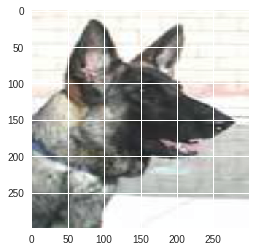

In [9]:
imshow(train_dset[22499][0])

## Creating data loader for training and validation datasets

In [0]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Inception V3 model

In [0]:
import torchvision.models.inception
my_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False

In [12]:
help(torchvision.models.inception.inception_v3)

Help on function inception_v3 in module torchvision.models.inception:

inception_v3(pretrained=False, **kwargs)
    Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet



In [13]:
imy_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False
my_inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
if is_cuda:
    my_inception = my_inception.cuda()

In [15]:
!pip install torchsummary

In [16]:
from torchsummary import summary

summary(my_inception, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

## Extracting Convolutional features

In [0]:
my_inception.Mixed_7a

In [0]:
# Create LayerActivations object to store the output of inception model at a particular layer.
trn_features = LayerActivations(my_inception.Mixed_7a)
trn_labels = []

In [19]:
trn_features

In [0]:
# Passing all the data through the model , as a side effect the outputs will get stored 
# in the features list of the LayerActivations object. 
for da,la in train_loader:
    _ = my_inception(Variable(da.cuda()))
    trn_labels.extend(la)
trn_features.remove()

In [0]:
# Repeat the same process for validation dataset .

val_features = LayerActivations(my_inception.Mixed_7a)
val_labels = []
for da,la in val_loader:
    _ = my_inception(Variable(da.cuda()))
    val_labels.extend(la)
val_features.remove()

In [23]:
len(val_labels)

2500

In [24]:
trn_features.features[0]

tensor([0.0000, 0.0000, 0.5720,  ..., 0.3371, 0.0000, 0.0000])

In [25]:
trn_features.features[0].size()

torch.Size([81920])

In [26]:
len(trn_features.features)

22500

## Creating train and validation feature dataset

In [0]:
#Dataset for pre computed features for train and validation data sets

trn_feat_dset = FeaturesDataset(trn_features.features,trn_labels)
val_feat_dset = FeaturesDataset(val_features.features,val_labels)

#Data loaders for pre computed features for train and validation data sets

trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [0]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size,training=True):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = F.dropout(inp, training=self.training)
        out = self.fc(out)
        return out

# The size of the output from the selected convolution feature 
fc_in_size = 81920

fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [0]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [33]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc.eval(),val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss is   1.5 and training accuracy is 21431.0/22500.0     95.25
validation loss is  0.19 and validation accuracy is 2478.0/2500.0     99.12
training loss is  0.16 and training accuracy is 22318.0/22500.0     99.19
validation loss is  0.15 and validation accuracy is 2479.0/2500.0     99.16
training loss is  0.25 and training accuracy is 22274.0/22500.0      99.0
validation loss is  0.21 and validation accuracy is 2486.0/2500.0     99.44
training loss is  0.17 and training accuracy is 22365.0/22500.0      99.4
validation loss is  0.16 and validation accuracy is 2489.0/2500.0     99.56
training loss is  0.23 and training accuracy is 22352.0/22500.0     99.34
validation loss is  0.53 and validation accuracy is 2473.0/2500.0     98.92
training loss is  0.28 and training accuracy is 22354.0/22500.0     99.35
validation loss is   1.6 and validation accuracy is 2428.0/2500.0     97.12
training loss is  0.12 and training accuracy is 22424.0/22500.0     99.66
validation loss is  0.26 a

In [0]:
optimizer.param_groups[0]['lr']= 0.0001

In [35]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss is 0.078 and training accuracy is 22457.0/22500.0     99.81
validation loss is  0.42 and validation accuracy is 2488.0/2500.0     99.52
training loss is 0.075 and training accuracy is 22465.0/22500.0     99.84
validation loss is  0.42 and validation accuracy is 2488.0/2500.0     99.52
training loss is 0.044 and training accuracy is 22478.0/22500.0      99.9
validation loss is  0.42 and validation accuracy is 2488.0/2500.0     99.52
training loss is 0.045 and training accuracy is 22475.0/22500.0     99.89
validation loss is  0.41 and validation accuracy is 2488.0/2500.0     99.52
training loss is 0.057 and training accuracy is 22472.0/22500.0     99.88
validation loss is   0.4 and validation accuracy is 2488.0/2500.0     99.52
training loss is  0.05 and training accuracy is 22473.0/22500.0     99.88
validation loss is   0.4 and validation accuracy is 2489.0/2500.0     99.56
training loss is  0.03 and training accuracy is 22476.0/22500.0     99.89
validation loss is   0.4 a

In [36]:
for epoch in range(1,100):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss is 0.025 and training accuracy is 22484.0/22500.0     99.93
validation loss is  0.39 and validation accuracy is 2489.0/2500.0     99.56
training loss is 0.033 and training accuracy is 22481.0/22500.0     99.92
validation loss is  0.39 and validation accuracy is 2490.0/2500.0      99.6
training loss is 0.041 and training accuracy is 22478.0/22500.0      99.9
validation loss is  0.38 and validation accuracy is 2490.0/2500.0      99.6
training loss is 0.041 and training accuracy is 22478.0/22500.0      99.9
validation loss is  0.38 and validation accuracy is 2489.0/2500.0     99.56
training loss is 0.021 and training accuracy is 22485.0/22500.0     99.93
validation loss is  0.38 and validation accuracy is 2490.0/2500.0      99.6
training loss is 0.025 and training accuracy is 22485.0/22500.0     99.93
validation loss is  0.38 and validation accuracy is 2490.0/2500.0      99.6
training loss is 0.034 and training accuracy is 22479.0/22500.0     99.91
validation loss is  0.37 a